<a href="https://colab.research.google.com/github/ehsanbarkhordar/Bank-Customer-Clustering-By-Transactions/blob/main/Czech_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, Embedding, TimeDistributed, Dropout, Bidirectional, Concatenate
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [3]:
from os import listdir
from os.path import isfile, join
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + '/lpetrocelli-retail-banking-demo-data/'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

['CRM Call Center Logs.csv',
 'CRM Events.csv',
 'completedcard.csv',
 'LuxuryLoanPortfolio.csv',
 'completedorder.csv',
 'completedloan.csv',
 'completedclient.csv',
 'completedacct.csv',
 'completedtrans.csv',
 'completeddistrict.csv',
 'CRM Reviews.csv',
 'completeddisposition.csv']

In [4]:
# Import Clients
df_clients = pd.read_csv(dataset_path+'completedclient.csv', index_col=[0], low_memory=False)
# Import Transactions
df_trans = pd.read_csv(dataset_path+'completedtrans.csv', index_col=[0], low_memory=False)
# Import Positions
df_positions = pd.read_csv(dataset_path+'completeddisposition.csv', index_col=[0], low_memory=False)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df_clients = df_clients.join(df_positions.set_index('client_id'), on='client_id')

In [6]:
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,A00011359,Owner


In [7]:
df_clients[['account_id','sex','age','zipcode']]

,account_id,sex,age,zipcode
client_id,,,,
C00000001,A00000001,Female,29,47246
C00000002,A00000002,Male,54,10040
C00000003,A00000002,Female,59,10162
C00000004,A00000003,Male,43,49047
C00000005,A00000003,Female,39,40852
...,...,...,...,...
C00013955,A00011349,Female,54,10121
C00013956,A00011349,Male,56,10118
C00013968,A00011359,Male,31,2721


In [8]:
zip_set=set(df_clients['zipcode'])
zip_list=list(df_clients['zipcode'])
print("all zip codes in dataset: ",len(zip_list))
print("unique zip codes in dataset: ",len(zip_set))

all zip codes in dataset:  5369
unique zip codes in dataset:  3512


In [9]:
df_clients_onehot = pd.DataFrame()

In [10]:
df_clients_onehot['account_id']=df_clients['account_id']

In [11]:
data=list(df_clients['sex'])
values = array(data)
print(values)
# integer encode
label_encoder = preprocessing.LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of sex onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['sex'] = onehot_encoded.tolist()

['Female' 'Male' 'Female' ... 'Male' 'Female' 'Female']
[0 1 0 ... 1 0 0]
shape of sex onehot_encoded:  (5369, 2)


In [12]:
data=list(df_clients['age'])
values = array(data)
print(values)
# integer encode
label_encoder = preprocessing.LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of age onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['age'] = onehot_encoded.tolist()

[29 54 59 ... 31 37 46]
[17 42 47 ... 19 25 34]
shape of age onehot_encoded:  (5369, 77)


In [13]:
data=list(df_clients['zipcode'])
values = array(data)
print(values)
# integer encode
label_encoder = preprocessing.LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of zipcode onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['zipcode'] = onehot_encoded.tolist()

[47246 10040 10162 ...  2721 48475 44244]
[2625  167  211 ...  118 3049 1677]
shape of zipcode onehot_encoded:  (5369, 3512)


In [14]:
df_clients_onehot['static_vector'] = df_clients_onehot.apply (lambda row: np.concatenate([row.sex, row.age, row.zipcode]), axis=1)

In [15]:
df_clients_onehot

,account_id,sex,age,zipcode,static_vector
client_id,,,,,
C00000001,A00000001,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000002,A00000002,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000003,A00000002,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000004,A00000003,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000005,A00000003,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
C00013955,A00011349,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013956,A00011349,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013968,A00011359,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
print("static vector dimention: ",df_clients_onehot.iloc[0]['static_vector'].shape)

static vector dimention:  (3591,)


In [17]:
# Convert date to python datetime
df_trans['fulldate'] = pd.to_datetime(df_trans['fulldate'],format="%Y-%m-%d")
df_trans['timestamp'] = df_trans.fulldate.values.astype(np.int64) // 10 ** 9

In [18]:
df_trans

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [19]:
df_trans = df_trans.sort_values('fulldate')

df_z_scaled = df_trans
df_z_scaled['amount'] = (df_z_scaled['amount'] - df_z_scaled['amount'].mean()) / df_z_scaled['amount'].std()
df_z_scaled['timestamp'] = (df_z_scaled['timestamp'] - df_z_scaled['timestamp'].mean()) / df_z_scaled['timestamp'].std()

df_trans_groupby_account_id = df_z_scaled.groupby(['account_id'])

In [20]:
df_z_scaled

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,-0.548597,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,-2.860870
2,T00171812,A00000576,Credit,Credit in Cash,-0.527595,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,-2.860870
3,T00207264,A00000704,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,-2.860870
4,T01117247,A00003818,Credit,Credit in Cash,-0.559098,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,-2.860870
5,T00579373,A00001972,Credit,Credit in Cash,-0.580101,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,-2.858917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053317,T03629556,A00002990,Credit,NaN,-0.603728,42712.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:14:06,2018-12-31T13:14:06,1.417798
1053316,T03630422,A00003025,Credit,NaN,-0.614345,15933.6,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:31:03,2018-12-31T13:31:03,1.417798
1053315,T03631495,A00003053,Credit,NaN,-0.585372,86982.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,16:53:60,2018-12-31T16:53:60,1.417798
1053321,T03632209,A00003077,Credit,NaN,-0.593973,68530.7,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:55:47,2018-12-31T14:55:47,1.417798


In [21]:
df = df_trans_groupby_account_id
df_trans_groupby_account_id.size()

account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Length: 4500, dtype: int64

In [22]:
# df.groups.keys()

In [23]:
max_length_of_transaction = df['amount'].count().max()
print("max trans lenght is: ", max_length_of_transaction)
df['amount'].count()

max trans lenght is:  675


account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Name: amount, Length: 4500, dtype: int64

In [24]:
df.get_group('A00000001')

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
149432,T00000001,A00000001,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2015,3,24,2015-03-24,10:21:45,2015-03-24T10:21:45,-1.274442
157404,T00000005,A00000001,Credit,Collection from Another Bank,-0.235767,4679.0,NaN,JPMorgan Chase,41403269.0,2015,4,13,2015-04-13,08:54:57,2015-04-13T08:54:57,-1.235367
158832,T00000199,A00000001,Credit,Credit in Cash,0.701044,17279.0,NaN,NaN,NaN,2015,4,23,2015-04-23,10:54:46,2015-04-23T10:54:46,-1.215830
162681,T03530438,A00000001,Credit,NaN,-0.620089,17298.2,Interest Credited,NaN,NaN,2015,4,30,2015-04-30,11:01:59,2015-04-30T11:01:59,-1.202154
167083,T00000006,A00000001,Credit,Collection from Another Bank,-0.235767,20977.2,NaN,JPMorgan Chase,41403269.0,2015,5,13,2015-05-13,10:33:00,2015-05-13T10:33:00,-1.176755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032336,T03530481,A00000001,Credit,NaN,-0.615059,16701.5,Interest Credited,NaN,NaN,2018,11,30,2018-11-30,13:58:35,2018-11-30T13:58:35,1.357232
1033713,T00000230,A00000001,Debit,Cash Withdrawal,-0.149552,12186.9,NaN,NaN,NaN,2018,12,3,2018-12-03,13:09:19,2018-12-03T13:09:19,1.363094
1035097,T00000097,A00000001,Debit,Remittance to Another Bank,-0.364616,9734.9,Household,State Street Corp.,87144583.0,2018,12,5,2018-12-05,11:42:20,2018-12-05T11:42:20,1.367001
1045493,T00000049,A00000001,Credit,Collection from Another Bank,-0.235767,13413.9,NaN,JPMorgan Chase,41403269.0,2018,12,13,2018-12-13,14:00:08,2018-12-13T14:00:08,1.382631


In [25]:
# my_list=[list(df_trans.loc[x][['amount','timestamp']])  for x in df.groups['A00000001']]

In [26]:
sequence_input_list = []
sequence_output_list = []

for k, v in df_trans.groupby('account_id'):
  user_trans_array = pd.concat([v.amount, v.timestamp], axis=1).values
  array = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1, -1], axis=0)
  input_array = np.append(add_start_to_array, [[-2, -2]], axis=0)
  output_array = np.append(array, [[-2, -2]], axis=0)
  # resize array to max_lenght
  input_array.resize((max_length_of_transaction,2), refcheck=False)
  output_array.resize((max_length_of_transaction,2), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)

In [27]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
sequence_output_array.shape

(4500, 675, 2)

In [28]:
(sequence_output_input_array==sequence_output_array).all()

False

In [29]:
sequence_output_array[0][239]

array([-2., -2.])

In [30]:
# Build static input array
list_of_account_ids = list(df.groups.keys())
static_input_list = []
for account_id in list_of_account_ids:
  sub_df = df_clients_onehot.loc[df_clients_onehot['account_id'] == account_id]
  account_static_vector = sub_df.iloc[0]['static_vector']
  static_input_list.append(account_static_vector)
static_input_array = np.array(static_input_list)
print(static_input_array.shape)
static_output_array = static_input_array
static_input_array

(4500, 3591)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [86]:
latent_dim = 64
# num_static_features = 3591

###########################################  encoder  ###########################################

#Sequence input shape is N*2 which N is sequence length and 2 is price and time
sequence_input = Input(name='sequence_input', shape=(None, 2))

#Static input shape is M which here is 'num_static_features'
# Satatic_input = Input(name='Satatic_input', shape=(num_static_features,))

#Applying a dense layer to static input
# Satatic_dense = Dense(512, activation = 'elu')(Satatic_input)

#Many_to_one_lstm
outputs  = LSTM(2048, return_sequences=True)(sequence_input)

outputs = GRU(1024, return_sequences=True)(outputs)

outputs = Dropout(0.2, input_shape=(2,))(outputs)

_ , hidden_state, cell_state = LSTM(512, return_state=True,return_sequences=True)(outputs)


latent_space = Concatenate()([hidden_state, cell_state])
#Layer below output can be used for clustering purposes
latent_space = Dense(latent_dim, activation = 'elu', name='latent_space')(latent_space)

###########################################  decoder  ###########################################

#Temporary input with a time step delay for producing sequence output
#This input is exacly similar to sequence_input with only this diffrence that has a time step delay
sequence_output_input = Input(name='sequence_output_input', shape=(None, 2))

#One to many GRU (because of its simplicity, we used GRU instead of LSTM)
sequence_output = GRU(latent_dim, return_sequences=True)(sequence_output_input,
                                                         initial_state = latent_space)

#Sequence output
sequence_output = TimeDistributed(Dense(2, activation='sigmoid'))(sequence_output)

#Static output
# static_output = Dense(num_static_features, activation = 'sigmoid')(latent_space)

#Model has three inputs and 2 outputs (last input is temorary)
model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [sequence_output])

model.compile(
    optimizer="adam", loss=["mse", "mse"],
)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, None, 2048)   16801792    sequence_input[0][0]             
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, None, 1024)   9443328     lstm_5[0][0]                     
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, None, 1024)   0           gru_6[0][0]                      
____________________________________________________________________________________________

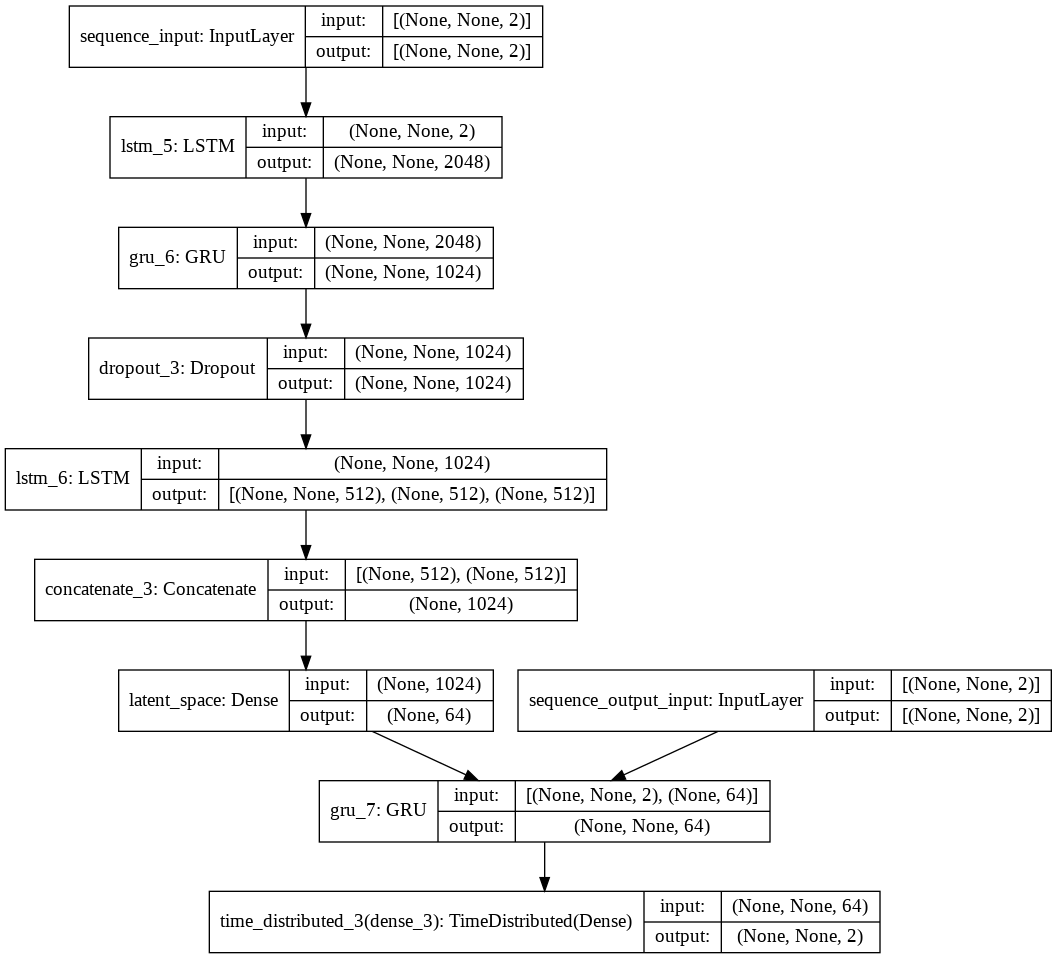

In [87]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [88]:
# fit the keras model on the dataset
batch_size = 128
inputs = [sequence_input_array, sequence_output_input_array]
outputs = [sequence_output_array]
model.fit(inputs, outputs, epochs=10, batch_size = batch_size)

Epoch 1/10
36/36 [==============================] - 169s 5s/step - loss: 0.4865
Epoch 2/10
36/36 [==============================] - 156s 4s/step - loss: 0.3604
Epoch 3/10
36/36 [==============================] - 156s 4s/step - loss: 0.3450
Epoch 4/10
36/36 [==============================] - 156s 4s/step - loss: 0.3506
Epoch 5/10
36/36 [==============================] - 156s 4s/step - loss: 0.3499
Epoch 6/10
36/36 [==============================] - 156s 4s/step - loss: 0.3577
Epoch 7/10
36/36 [==============================] - 156s 4s/step - loss: 0.3615
Epoch 8/10
36/36 [==============================] - 156s 4s/step - loss: 0.3476
Epoch 9/10
36/36 [==============================] - 156s 4s/step - loss: 0.3486
Epoch 10/10
36/36 [==============================] - 156s 4s/step - loss: 0.3557


In [89]:
# save the model to disk
# model.save(my_drive_path)

In [90]:
# load model
# model = keras.models.load_model(my_drive_path)

In [91]:
encoder = Model( model.input , model.get_layer("latent_space").output)

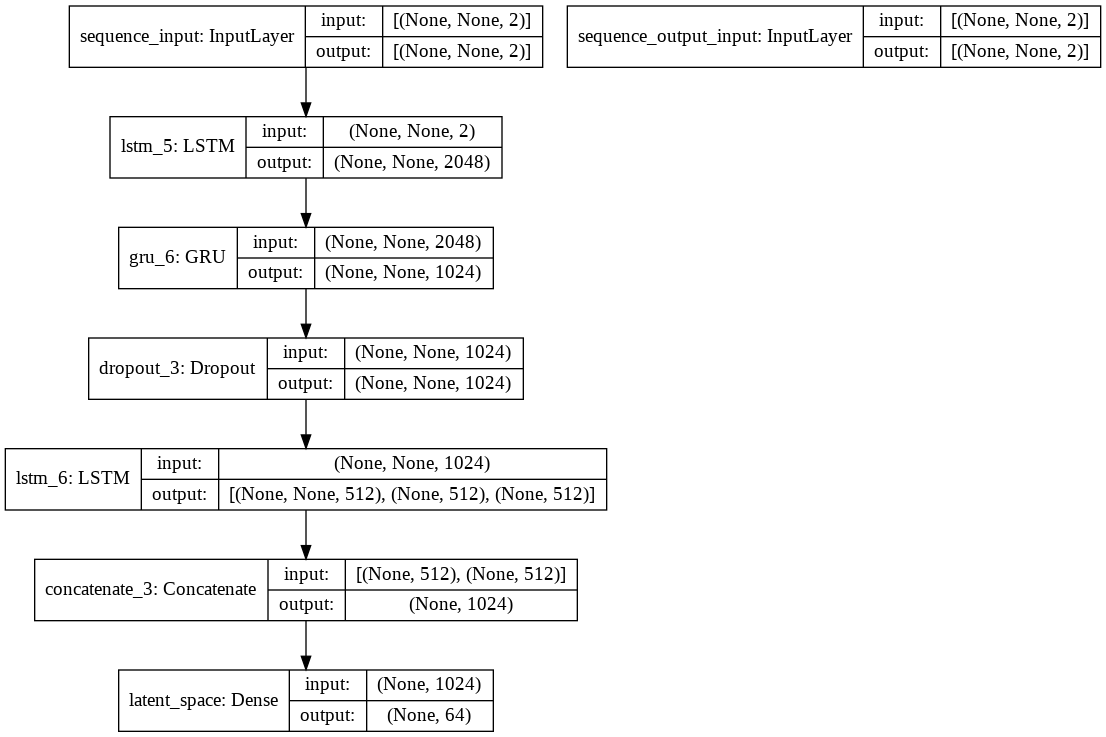

In [92]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

In [93]:
x = [sequence_input_array, sequence_output_input_array]
predictions = encoder.predict(x, batch_size = batch_size)

In [94]:
predictions.shape

(4500, 64)

In [95]:
standard_x = StandardScaler().fit_transform(predictions)

In [96]:
standard_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [97]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(standard_x)

In [98]:
principal_components

array([[-1.7131168 ,  0.5558279 , -0.9976614 ],
       [-5.191768  , -0.06595644,  1.0664024 ],
       [ 4.789895  ,  0.20565723,  0.05355271],
       ...,
       [-1.6273417 ,  1.3783404 ,  1.1951141 ],
       [ 1.1003951 ,  4.0846934 ,  0.9382013 ],
       [ 0.10897528, -0.08683659, -0.82425994]], dtype=float32)

In [99]:
kmeans = KMeans(n_clusters=10)
y_kmeans = kmeans.fit_predict(principal_components)

In [100]:
kmeans.labels_

array([0, 4, 7, ..., 3, 3, 6], dtype=int32)

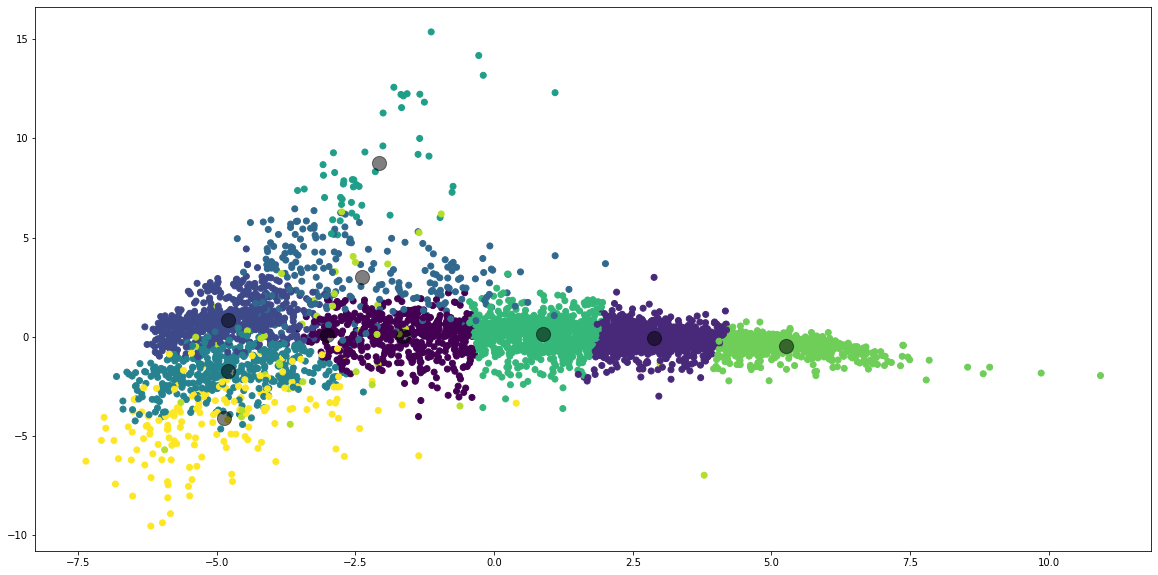

In [101]:
fig = plt.figure(figsize=(20,10))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

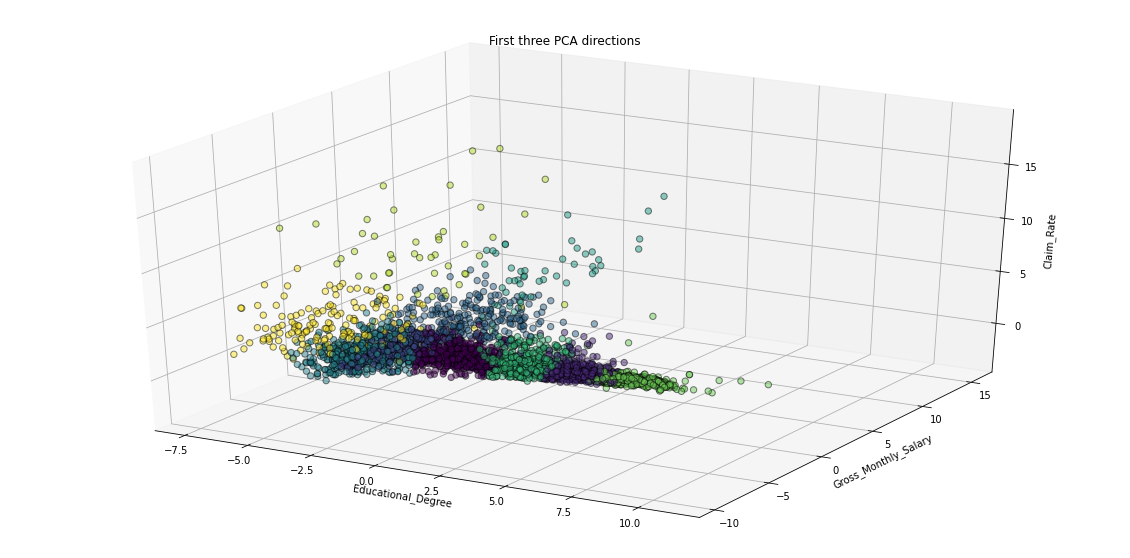

In [102]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:,0],principal_components[:,1],principal_components[:,2], 
            c=y_kmeans, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)


ax.set_title("First three PCA directions")
ax.set_xlabel("Educational_Degree")
ax.set_ylabel("Gross_Monthly_Salary")
ax.set_zlabel("Claim_Rate")
ax.dist = 10